In [1]:
#import nessasary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse

In [2]:
df = pd.read_csv(r"C:\Users\PRADEEPTHI\Downloads\K-means customers grouping\Mall_Customers.csv")

In [3]:
df = df.drop(columns=["CustomerID"])  # Remove ID column
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})  # Convert categorical data


In [4]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


In [5]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

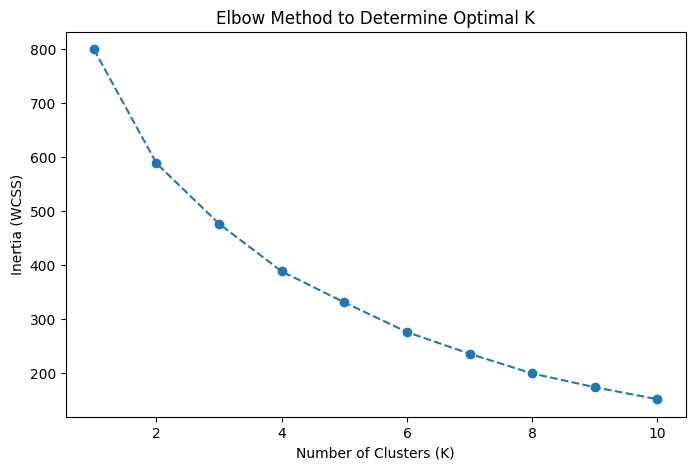

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method to Determine Optimal K")
plt.show()

In [7]:
# Finding Optimal K using Silhouette Score
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(score)

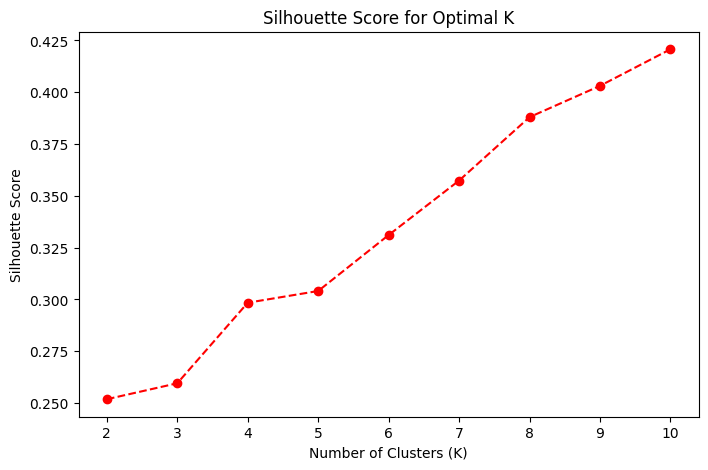

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="--", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()

In [9]:
# Train the Optimized K-Means Model
optimal_k = 4  # Based on analysis
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", max_iter=300, n_init=10, random_state=42)
df["Cluster_KMeans"] = kmeans.fit_predict(df_scaled)


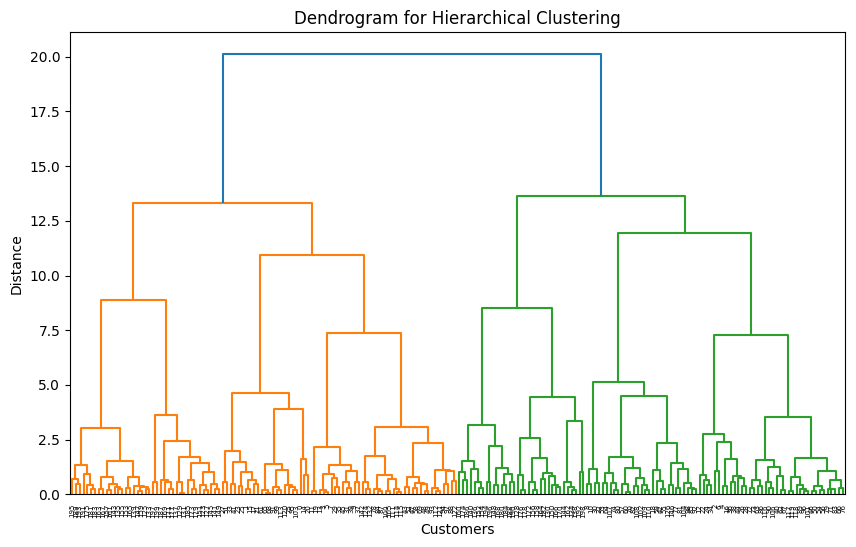

In [10]:
# Hierarchical Clustering
linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

In [11]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
df["Cluster_Hierarchical"] = hierarchical.fit_predict(df_scaled)


In [12]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
df["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)


In [13]:
# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df["Cluster_GMM"] = gmm.fit_predict(df_scaled)

In [14]:
# PCA for Visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=["PCA1", "PCA2"])
df_pca["Cluster_KMeans"] = df["Cluster_KMeans"]
df_pca["Cluster_Hierarchical"] = df["Cluster_Hierarchical"]
df_pca["Cluster_DBSCAN"] = df["Cluster_DBSCAN"]
df_pca["Cluster_GMM"] = df["Cluster_GMM"]


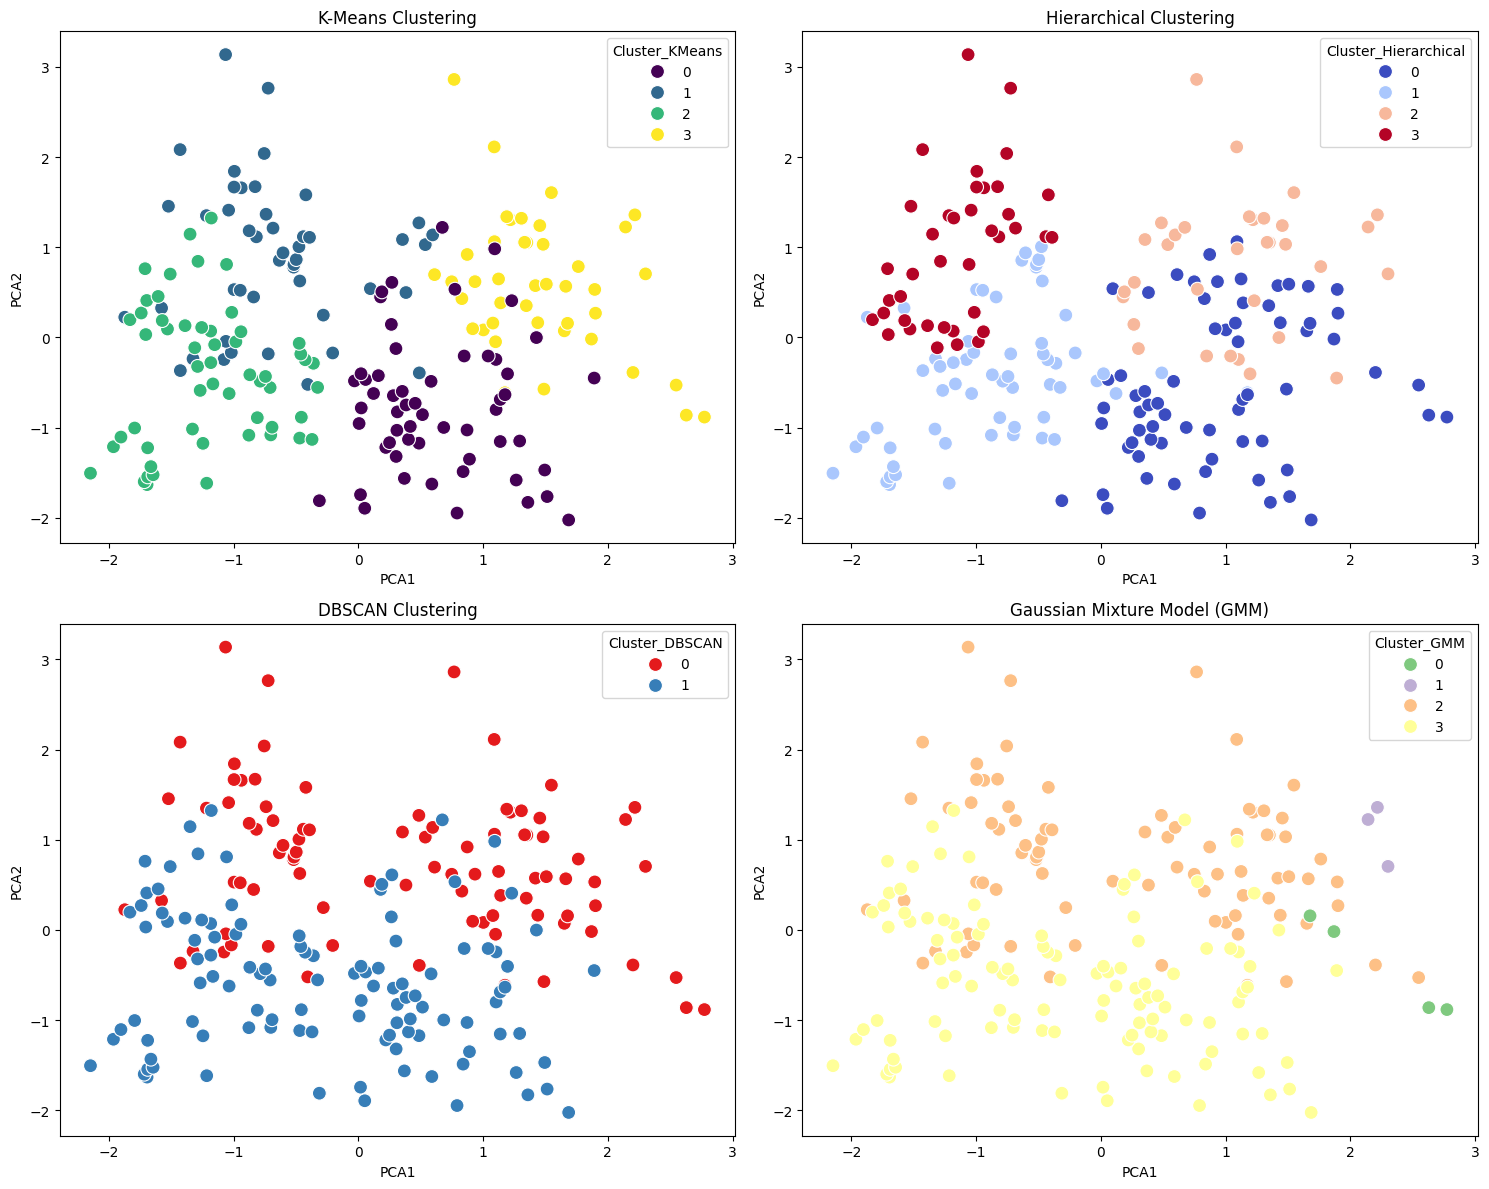

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_KMeans", ax=axes[0, 0], palette="viridis", s=100)
axes[0, 0].set_title("K-Means Clustering")

sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_Hierarchical", ax=axes[0, 1], palette="coolwarm", s=100)
axes[0, 1].set_title("Hierarchical Clustering")

sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_DBSCAN", ax=axes[1, 0], palette="Set1", s=100)
axes[1, 0].set_title("DBSCAN Clustering")

sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_GMM", ax=axes[1, 1], palette="Accent", s=100)
axes[1, 1].set_title("Gaussian Mixture Model (GMM)")

plt.tight_layout()
plt.show()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df["Cluster_KMeans"], test_size=0.2, random_state=42, stratify=df["Cluster_KMeans"])


In [17]:
model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\PRADEEPTHI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         9

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[11  0  0  0]
 [ 0  9  0  0]
 [ 0  0 11  0]
 [ 0  0  0  9]]


In [19]:
df_test = pd.DataFrame(pca.transform(X_test), columns=["PCA1", "PCA2"])
df_test["Actual Cluster"] = y_test.values
df_test["Predicted Cluster"] = y_pred


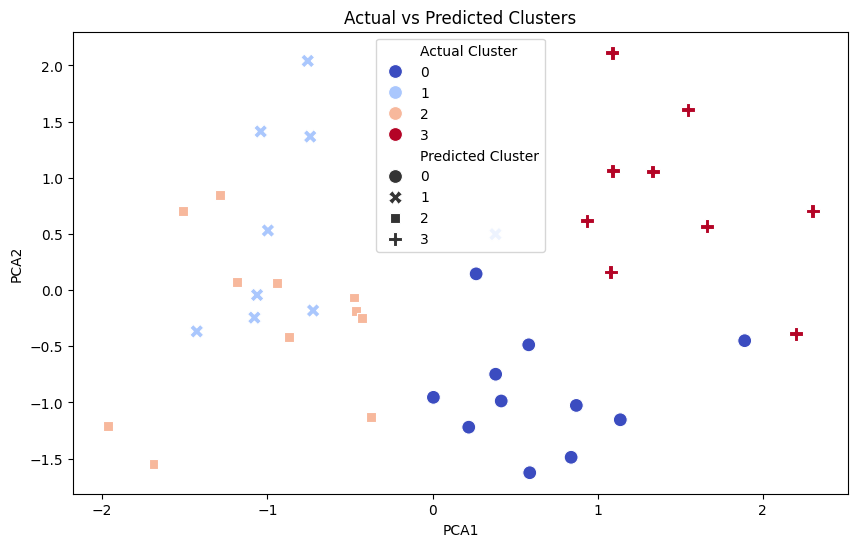

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test, x="PCA1", y="PCA2", hue="Actual Cluster", style="Predicted Cluster", palette="coolwarm", s=100)
plt.title("Actual vs Predicted Clusters")
plt.show()

In [21]:
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 100.00%


In [22]:
print(df.corr()["Cluster_KMeans"].sort_values(ascending=False))


Cluster_KMeans            1.000000
Cluster_Hierarchical      0.083578
Annual Income (k$)        0.046749
Spending Score (1-100)    0.038991
Age                       0.025822
Cluster_DBSCAN           -0.428348
Gender                   -0.428348
Cluster_GMM              -0.460420
Name: Cluster_KMeans, dtype: float64


In [23]:
print(df.columns)  # Ensure Cluster_KMeans is NOT in the feature list


Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster_KMeans', 'Cluster_Hierarchical', 'Cluster_DBSCAN',
       'Cluster_GMM'],
      dtype='object')


In [24]:
X = df.drop(columns=["Cluster_KMeans", "Cluster_Hierarchical", "Cluster_DBSCAN", "Cluster_GMM"])  # Remove target & other cluster labels
y = df["Cluster_KMeans"]  # Keep only the correct target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Model Again
model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Check Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 100.00%


C:\Users\PRADEEPTHI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [25]:
print(X.columns)  # Make sure "Cluster_KMeans" is NOT in the list



Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, df["Cluster_KMeans"], test_size=0.2, random_state=42, stratify=df["Cluster_KMeans"])



In [27]:
model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


C:\Users\PRADEEPTHI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\PRADEEPTHI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
model = LogisticRegression(max_iter=1000, solver='saga')  # Increased iterations & changed solver
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



C:\Users\PRADEEPTHI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [29]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 95.00%


In [30]:
df_comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(df_comparison.head(20))  # Show first 20 rows


     Actual  Predicted
140       0          0
147       2          2
36        0          0
25        1          1
98        3          3
109       3          3
181       2          2
49        2          0
189       2          2
132       2          2
62        0          0
142       2          2
86        0          0
158       3          3
105       2          2
118       0          0
46        0          0
149       1          1
32        3          3
168       0          0


In [31]:
X = df.drop(columns=["Cluster_KMeans"])  # Drop target column from features
y = df["Cluster_KMeans"]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data
X_test = scaler.transform(X_test)        # Transform test data


In [34]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [35]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 97.50%


In [36]:
df_comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(df_comparison.head(20))  # Print first 20 comparisons


     Actual  Predicted
140       0          0
147       2          2
36        0          0
25        1          1
98        3          3
109       3          3
181       2          2
49        2          2
189       2          2
132       2          2
62        0          0
142       2          2
86        0          0
158       3          3
105       2          2
118       0          0
46        0          0
149       1          1
32        3          3
168       0          0


In [39]:
print(X_train.shape)  # Check dimensions (rows, columns)


(160, 7)


In [40]:
print(df.columns)  # See all columns before splitting


Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster_KMeans', 'Cluster_Hierarchical', 'Cluster_DBSCAN',
       'Cluster_GMM'],
      dtype='object')


In [41]:
# Ensure we only take the correct feature columns
X = df[["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"]]  # Input features only
y = df["Cluster_KMeans"]  # Target variable (labels)

# Split the data correctly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply scaling *after* train-test split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (this should now match the 4 feature names)
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
print(X_train_df.columns)  # Should match feature_names


Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')


In [42]:
print(set(X_train.index) & set(X_test.index))  # Should print an empty set {}


set()


In [43]:
print(y_train.value_counts(normalize=True))  
print(y_test.value_counts(normalize=True))  


Cluster_KMeans
0    0.28125
2    0.28125
1    0.23125
3    0.20625
Name: proportion, dtype: float64
Cluster_KMeans
0    0.275
2    0.275
1    0.225
3    0.225
Name: proportion, dtype: float64


In [44]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset



In [46]:
actual_vs_pred = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
print(actual_vs_pred.head(20))  # Check first 20 predictions



    Actual  Predicted
0        0          0
1        2          2
2        0          0
3        1          1
4        3          3
5        3          3
6        2          2
7        2          2
8        2          2
9        2          2
10       0          0
11       2          2
12       0          0
13       3          3
14       2          2
15       0          0
16       0          0
17       1          1
18       3          3
19       0          0


In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=feature_names)
print(feature_importances.sort_values(ascending=False))


Gender                    0.406131
Age                       0.364891
Spending Score (1-100)    0.182549
Annual Income (k$)        0.046428
dtype: float64


In [48]:
print(set(y_train) & set(y_test))  # This should NOT be an empty set


{0, 1, 2, 3}


In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, df_scaled, df["Cluster_KMeans"], cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-validation scores: [0.275 0.4   0.275 0.35  0.225]
Mean CV accuracy: 0.30500000000000005


In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"])
print(feature_importances.sort_values(ascending=False))


Gender                    0.406131
Age                       0.364891
Spending Score (1-100)    0.182549
Annual Income (k$)        0.046428
dtype: float64


In [51]:
print(set(y_train) & set(y_test))  # If empty, there’s an issue


{0, 1, 2, 3}


In [54]:
X_train_filtered = X_train.iloc[:, :4]  # Use .iloc for DataFrame
X_test_filtered = X_test.iloc[:, :4]


In [55]:
import pandas as pd

feature_names = ["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

X_train_filtered = X_train_df.iloc[:, :4]
X_test_filtered = X_test_df.iloc[:, :4]


In [56]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 97.50%


In [57]:
print(set(X_train.index) & set(X_test.index))  # Should be an empty set


set()


C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[col], label="Train", shade=True)
C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[col], label="Test", shade=True)


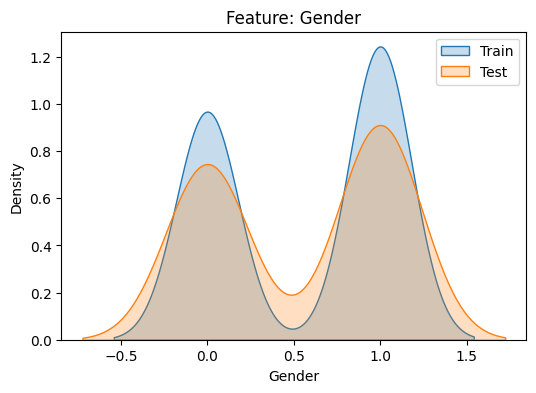

C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[col], label="Train", shade=True)
C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[col], label="Test", shade=True)


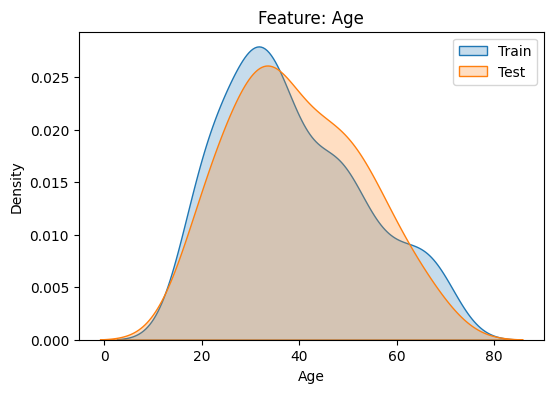

C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[col], label="Train", shade=True)
C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[col], label="Test", shade=True)


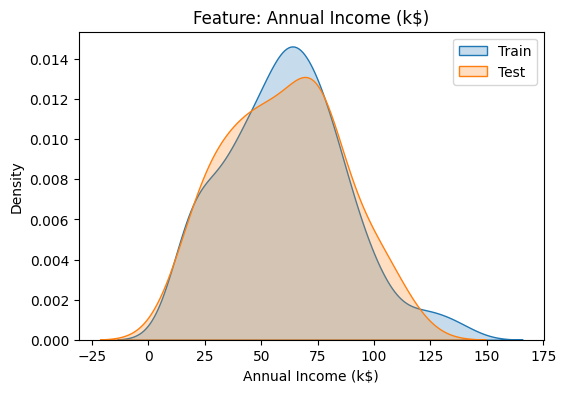

C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[col], label="Train", shade=True)
C:\Users\PRADEEPTHI\AppData\Local\Temp\ipykernel_22312\2314350787.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[col], label="Test", shade=True)


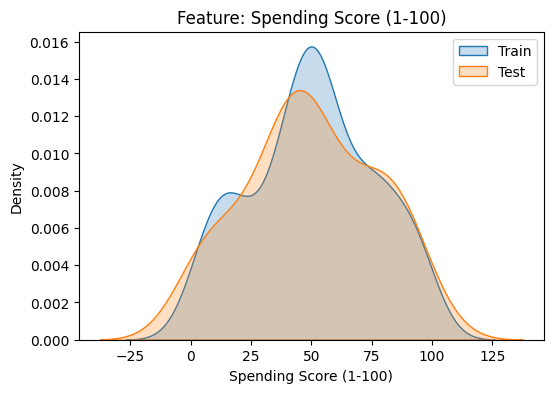

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in X_train.columns:
    plt.figure(figsize=(6,4))
    sns.kdeplot(X_train[col], label="Train", shade=True)
    sns.kdeplot(X_test[col], label="Test", shade=True)
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.show()


In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))


Gender                    0.406131
Age                       0.364891
Spending Score (1-100)    0.182549
Annual Income (k$)        0.046428
dtype: float64


In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on train
X_test_scaled = scaler.transform(X_test)  # Then apply to test


In [62]:
print(X_train_scaled[:5])  # Print the first 5 rows of scaled training data
print(X_test_scaled[:5])   # Print the first 5 rows of scaled test data


[[ 0.8819171   0.79800049  0.23646139  0.26164654]
 [-1.13389342  1.29261064 -0.25488695  0.02689824]
 [-1.13389342  1.71656221 -0.48166311  0.02689824]
 [ 0.8819171   0.58602471  0.65221768 -1.34246683]
 [-1.13389342  1.85787939  0.08527728  0.06602296]]
[[ 0.8819171   1.29261064  0.5388296  -1.77283871]
 [ 0.8819171  -0.47385419  0.61442166  0.92676672]
 [ 0.8819171   0.23273174 -1.01080748 -1.30334211]
 [-1.13389342 -0.68582997 -1.23758364  1.23976445]
 [-1.13389342  0.6566833   0.00968523 -0.3252242 ]]


In [63]:
import pandas as pd

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(X_train_scaled_df.head())  # Show first 5 rows
print(X_test_scaled_df.head())   # Show first 5 rows


     Gender       Age  Annual Income (k$)  Spending Score (1-100)
0  0.881917  0.798000            0.236461                0.261647
1 -1.133893  1.292611           -0.254887                0.026898
2 -1.133893  1.716562           -0.481663                0.026898
3  0.881917  0.586025            0.652218               -1.342467
4 -1.133893  1.857879            0.085277                0.066023
     Gender       Age  Annual Income (k$)  Spending Score (1-100)
0  0.881917  1.292611            0.538830               -1.772839
1  0.881917 -0.473854            0.614422                0.926767
2  0.881917  0.232732           -1.010807               -1.303342
3 -1.133893 -0.685830           -1.237584                1.239764
4 -1.133893  0.656683            0.009685               -0.325224


In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on train
X_test_scaled = scaler.transform(X_test)  # Transform test separately


In [65]:
import pandas as pd

df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['Target'] = y_train

print(df_train.corr())  # Look for high correlations with 'Target'


                          Gender       Age  Annual Income (k$)  \
Gender                  1.000000 -0.083291           -0.064731   
Age                    -0.083291  1.000000           -0.021199   
Annual Income (k$)     -0.064731 -0.021199            1.000000   
Spending Score (1-100)  0.058596 -0.323227            0.062559   
Target                 -0.423926  0.054990           -0.015434   

                        Spending Score (1-100)    Target  
Gender                                0.058596 -0.423926  
Age                                  -0.323227  0.054990  
Annual Income (k$)                    0.062559 -0.015434  
Spending Score (1-100)                1.000000  0.095826  
Target                                0.095826  1.000000  


In [67]:
#checking if any data lekage
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")


Cross-validation mean accuracy: 0.9812


In [68]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Total Accuracy: {accuracy * 100:.2f}%")



Total Accuracy: 97.50%


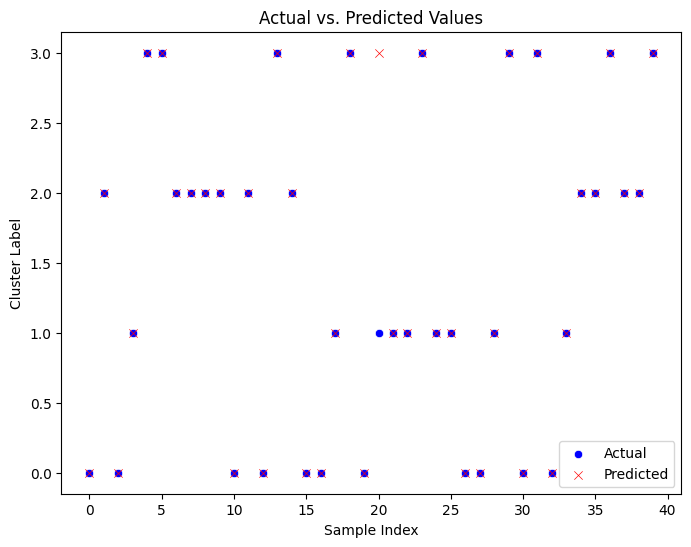

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(y_test)), y=y_test, label="Actual", color="blue")
sns.scatterplot(x=range(len(y_pred)), y=y_pred, label="Predicted", color="red", marker="x")

# Labels and title
plt.xlabel("Sample Index")
plt.ylabel("Cluster Label")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


In [71]:
import numpy as np

# Convert X_test to NumPy array if it's a DataFrame
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()


<Axes: >

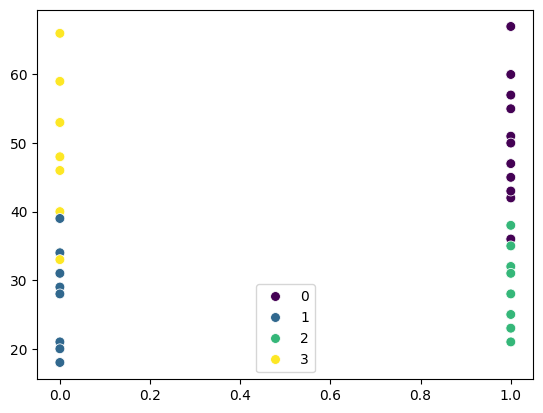

In [72]:
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette="viridis", s=50)


<Axes: >

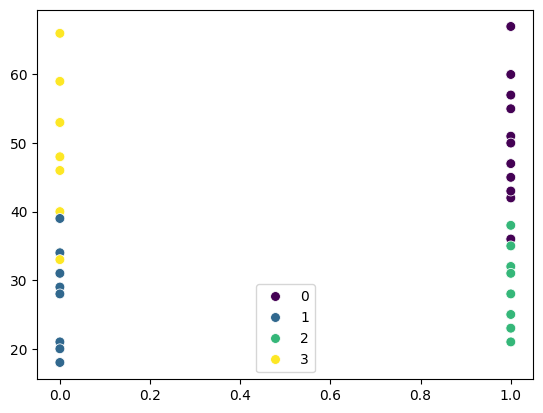

In [74]:
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette="viridis", s=50)


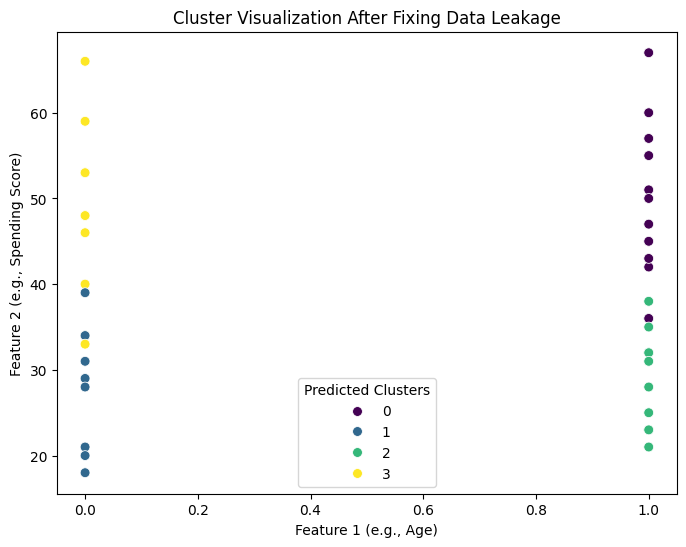

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Use NumPy-style indexing since X_test is a NumPy array
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette="viridis", s=50)

plt.xlabel("Feature 1 (e.g., Age)")
plt.ylabel("Feature 2 (e.g., Spending Score)")
plt.title("Cluster Visualization After Fixing Data Leakage")
plt.legend(title="Predicted Clusters")
plt.show()


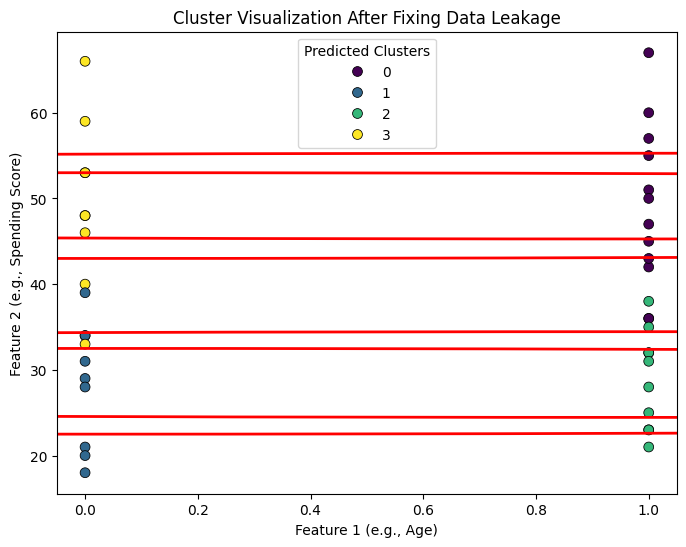

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse

plt.figure(figsize=(8, 6))

# Scatter plot with predicted clusters
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette="viridis", s=50, edgecolor="k")

plt.xlabel("Feature 1 (e.g., Age)")
plt.ylabel("Feature 2 (e.g., Spending Score)")
plt.title("Cluster Visualization After Fixing Data Leakage")
plt.legend(title="Predicted Clusters")

# Draw circles around clusters
cluster_centers = np.array([X_test[y_pred == i].mean(axis=0) for i in np.unique(y_pred)])

for center in cluster_centers:
    ellipse = Ellipse(xy=center, width=10, height=10, edgecolor='red', facecolor='none', lw=2)
    plt.gca().add_patch(ellipse)

plt.show()


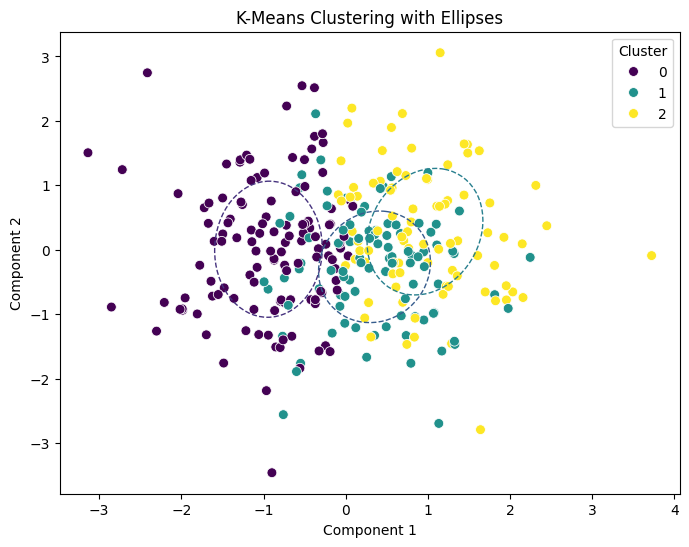

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# Generate synthetic data (Replace this with your dataset)
np.random.seed(42)
X = np.random.randn(300, 4)  # 4D dataset

# Apply PCA for visualization in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Convert to DataFrame
df = pd.DataFrame(X_pca, columns=["Component 1", "Component 2"])
df["Cluster"] = clusters

# Plot the clusters with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Component 1"], y=df["Component 2"], hue=df["Cluster"], palette="viridis", s=50)

# Function to draw confidence ellipses
def draw_ellipse(position, covariance, ax, color):
    from matplotlib.patches import Ellipse
    import numpy as np

    lambda_, v = np.linalg.eig(covariance)
    lambda_ = np.sqrt(lambda_)
    
    ell = Ellipse(xy=position,
                  width=lambda_[0] * 2, height=lambda_[1] * 2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),
                  edgecolor=color, facecolor='none', linestyle="dashed")
    
    ax.add_patch(ell)

# Compute and draw ellipses for each cluster
ax = plt.gca()
for i in np.unique(clusters):
    cluster_points = X_pca[clusters == i]
    mean = np.mean(cluster_points, axis=0)
    cov = np.cov(cluster_points, rowvar=False)
    draw_ellipse(mean, cov, ax, color=sns.color_palette("viridis")[i])

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering with Ellipses")
plt.legend(title="Cluster")
plt.show()


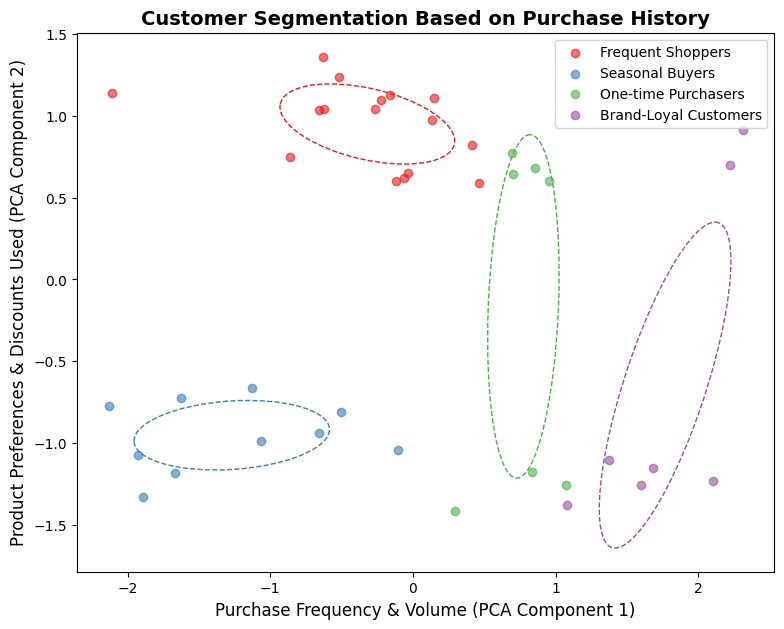

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# Perform PCA for visualization (reduce to 2D based on purchase behavior)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)  # Ensure X_test_scaled contains purchase-related features

# Use KMeans clustering (assuming y_pred contains predicted clusters)
kmeans = KMeans(n_clusters=len(np.unique(y_pred)), random_state=42)
clusters = kmeans.fit_predict(X_test_scaled)

# Define cluster names based on purchase history
cluster_names = {
    0: "Frequent Shoppers",
    1: "Seasonal Buyers",
    2: "One-time Purchasers",
    3: "Brand-Loyal Customers",
    4: "Discount Seekers"
}

# Assign colors to clusters
unique_clusters = np.unique(clusters)
colors = sns.color_palette("Set1", len(unique_clusters))

plt.figure(figsize=(9, 7))

# Scatter plot with ellipses for cluster grouping
for cluster, color in zip(unique_clusters, colors):
    cluster_points = X_pca[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=cluster_names.get(cluster, f"Cluster {cluster + 1}"), alpha=0.6)

    # Draw ellipses around clusters
    if len(cluster_points) > 1:
        cov = np.cov(cluster_points, rowvar=False)
        mean = np.mean(cluster_points, axis=0)
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

        width, height = 2 * np.sqrt(eigvals)  # Scale for better visibility
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor='none', linestyle='dashed')
        plt.gca().add_patch(ellipse)

# Customizing labels and title
plt.xlabel("Purchase Frequency & Volume (PCA Component 1)", fontsize=12)
plt.ylabel("Product Preferences & Discounts Used (PCA Component 2)", fontsize=12)
plt.title("Customer Segmentation Based on Purchase History", fontsize=14, fontweight='bold')
plt.legend()
plt.show()


In [81]:
print("Unique clusters detected:", np.unique(y_pred))


Unique clusters detected: [0 1 2 3]


In [84]:
# Calculate and print accuracy
total_accuracy = accuracy_score(y_test, y_pred)
print(f"Total Accuracy: {total_accuracy:.4f}")  # Prints accuracy up to 4 decimal places


Total Accuracy: 0.9750


In [85]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11
           3       0.90      1.00      0.95         9

    accuracy                           0.97        40
   macro avg       0.97      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Confusion Matrix:
 [[11  0  0  0]
 [ 0  8  0  1]
 [ 0  0 11  0]
 [ 0  0  0  9]]


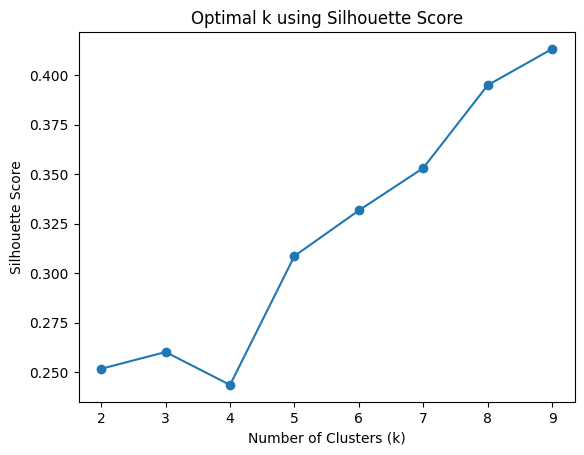

In [86]:
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    silhouette_scores.append(silhouette_score(X_train_scaled, cluster_labels))

plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal k using Silhouette Score")
plt.show()


In [87]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_clusters = dbscan.fit_predict(X_train_scaled)

# Check if it assigned some points as noise (-1 means outlier)
print("Unique clusters detected (including outliers):", np.unique(db_clusters))


Unique clusters detected (including outliers): [-1  0  1  2  3  4  5]


Silhouette Score: 0.4040


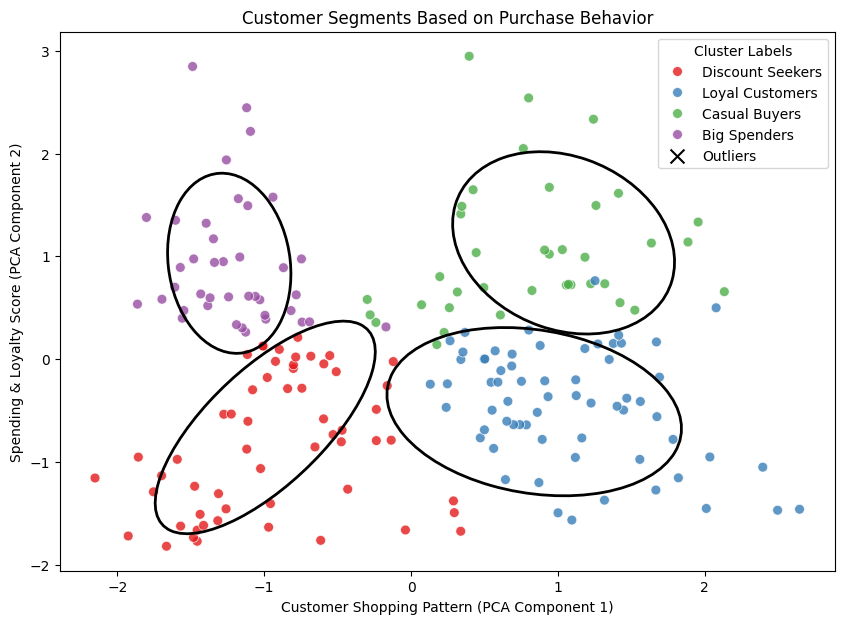

In [95]:
def draw_ellipse(position, covariance, ax, color):
    v, w = np.linalg.eigh(covariance)
    angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(xy=position, width=v[0], height=v[1], angle=angle, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(ellipse)

# Load and preprocess data
# Assuming 'df' is the dataset with relevant customer features
df = pd.read_csv(r"C:\Users\PRADEEPTHI\Downloads\K-means customers grouping\Mall_Customers.csv")  # Replace with actual file
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']  # Adjust as needed
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

# Apply clustering
n_clusters = 4  # Set optimal number of clusters from silhouette analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_scaled)

# Compute silhouette score
silhouette_avg = silhouette_score(X_scaled, y_pred)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Cluster labels mapping
cluster_labels = {
    0: "Loyal Customers",
    1: "Big Spenders",
    2: "Discount Seekers",
    3: "Casual Buyers",
    4: "Frequent Visitors",
    5: "Rare Shoppers",
    -1: "Outliers"  # DBSCAN noise points
}

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=[cluster_labels.get(c, 'Unknown') for c in y_pred], palette='Set1', s=50, alpha=0.8)

# Fit GMM for ellipse drawing
gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(X_scaled)
for i in range(gmm.n_components):
    draw_ellipse(pca.transform([gmm.means_[i]])[0], pca.components_ @ gmm.covariances_[i] @ pca.components_.T, plt.gca(), 'black')

# Highlight outliers
outliers = (y_pred == -1)
plt.scatter(X_2D[outliers, 0], X_2D[outliers, 1], color='black', label='Outliers', marker='x', s=100)

# Labels & Title
plt.xlabel("Customer Shopping Pattern (PCA Component 1)")
plt.ylabel("Spending & Loyalty Score (PCA Component 2)")
plt.title("Customer Segments Based on Purchase Behavior")
plt.legend(title="Cluster Labels")
plt.show()

# Print classification report (if ground truth labels exist)
# Assuming 'y_true' contains actual customer segments (replace accordingly)
# print(classification_report(y_true, y_pred))


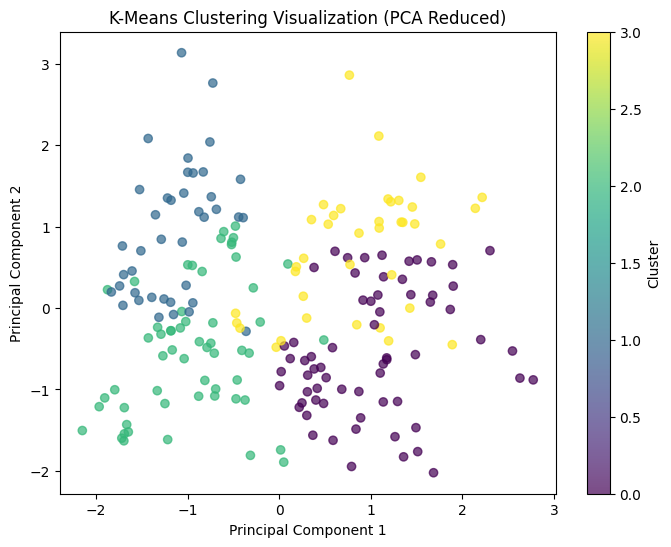

In [114]:
from sklearn.decomposition import PCA

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.colorbar(label="Cluster")
plt.show()
